based on https://stackoverflow.com/questions/59381695/lstm-in-pytorch-how-to-add-change-sequence-length-dimension

In [1]:
from fastai.tabular import *
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline

# Data preparation

## Get the data

In [2]:
class CryptoDataset:
    """Face Landmarks dataset."""
    TARGET_COLUMN_NAME = 'close'
    DATE_COLUMN_NAME = 'date'
    ELAPSED = 'Elapsed'
    DROP_COLUMNS =['Second', 'Month', 'Year', \
                   'Is_quarter_end', 'Is_quarter_start', \
                   'Is_year_end', 'Is_year_start',
                   'Is_month_end', 'Is_month_start',
                   'Week', 'Dayofyear', ELAPSED]
    True_target_column_name = TARGET_COLUMN_NAME+'_future'

    def __init__(self, csv_file="BTC-ETH-filtered_with_indicators.csv", predict_delta=4, sequence_size=10, batch_size=8):
        """
        Args:
            csv_file (string): Path to the csv file with the crypto stats table.
        """
        from datetime import datetime
        self.sequence_size = sequence_size
        self.df = pd.read_csv("BTC-ETH-filtered_with_indicators.csv",
                              #read dates as dates
                              parse_dates=[self.DATE_COLUMN_NAME],
                              date_parser=lambda x: datetime.fromtimestamp(int(x)))
        add_datepart(self.df, self.DATE_COLUMN_NAME, time=True);
        self.df = self.df.astype(float).drop(columns=self.DROP_COLUMNS)
        self.df[self.True_target_column_name] = self.df[self.TARGET_COLUMN_NAME].shift(-predict_delta)
        trvate_split = tuple(int(x * len(self.df)) for x in (0.75, 0.9, 1.0))
        tmp_train_limit = trvate_split[0]- trvate_split[0]%sequence_size
        self.train_df = self.df[:tmp_train_limit]
        tmp_valid_limit = trvate_split[1] - trvate_split[0]%sequence_size -(trvate_split[1]-trvate_split[0])%sequence_size
        self.valid_df = self.df[tmp_train_limit:tmp_valid_limit]
        self.test_df = self.df[tmp_valid_limit:(len(self.df)- len(self.df)%sequence_size)]
        del tmp_train_limit, tmp_valid_limit
        
        preprocessing_pipeline = Pipeline([("poli-feature", PolynomialFeatures(degree=2)),
                                           ("normalizer", StandardScaler())
                                          ]).fit(self.train_df.input_data(), self.train_df.target())
        temp = preprocessing_pipeline["poli-feature"].get_feature_names(self.train_df.input_data().columns)
        self.train_data = self.__transform_df(self.train_df.input_data(), preprocessing_pipeline, columns=temp)
        self.valid_data = self.__transform_df(self.valid_df.input_data(), preprocessing_pipeline, columns=temp)
        self.test_data = self.__transform_df(self.test_df.input_data(), preprocessing_pipeline, columns=temp)

        del temp

        self.train_data.drop(columns=['1'], inplace=True)
        self.valid_data.drop(columns=['1'], inplace=True)
        self.test_data.drop(columns=['1'], inplace=True)
        
        def create_inout_sequences(input_data: pd.DataFrame, labels: pd.DataFrame, seq_len: int):
            out_labels = torch.tensor(labels.iloc[seq_len-1:].values.astype(np.float32))
            print(input_data.shape)
            out_sequences = np.stack([input_data.iloc[i:i+seq_len] for i in range(len(input_data)-seq_len+1)])
            out_data = torch.tensor(out_sequences.reshape(-1, seq_len, input_data.shape[-1]).astype(np.float32))
            print(input_data.shape, out_data.shape, out_labels.shape)
            return out_data, out_labels
        
#         train_x_y
        self.train_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.train_data,
                                                                                     labels=self.train_df.target(),
                                                                                     seq_len=sequence_size)),
                                       batch_size=batch_size, shuffle = True)
        self.val_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.valid_data,
                                                                                   labels=self.valid_df.target(),
                                                                                   seq_len=sequence_size)),
                                       batch_size=batch_size)
        self.test_loader = DataLoader(dataset=TensorDataset(*create_inout_sequences(input_data=self.test_data,
                                                                                    labels=self.test_df.target(),
                                                                                    seq_len=sequence_size)),
                                       batch_size=batch_size)

    def __transform_df(self, df_to_transform, transformer, columns):
        return pd.DataFrame(transformer.transform(df_to_transform), columns=columns)
    
def input_data(self: pd.DataFrame):
    return self.drop(columns=[CryptoDataset.True_target_column_name])
def target(self: pd.DataFrame):
    return self[[CryptoDataset.True_target_column_name]]

pd.DataFrame.input_data = input_data
pd.DataFrame.target = target

### Check for NANs

In [3]:
# [(column, sum(df[column].isna())) for column in df.columns]

# Train

In [3]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda')

In [4]:
BATCH_SIZE = 32
SEQUENCE_SIZE = 4
dataset=CryptoDataset(predict_delta=1,
                      batch_size=BATCH_SIZE,
                      sequence_size=SEQUENCE_SIZE)

(1044, 2015)
(1044, 2015) torch.Size([1041, 4, 2015]) torch.Size([1041, 1])
(208, 2015)
(208, 2015) torch.Size([205, 4, 2015]) torch.Size([205, 1])
(144, 2015)
(144, 2015) torch.Size([141, 4, 2015]) torch.Size([141, 1])


## Model

In [5]:
class SentimentNet(nn.Module):
    def __init__(self, features, output_size=1,
#                  embedding_dim=10,
#                  hidden_dim=50,
                 sequence_size=10,
                 n_layers=1,
                 drop_prob=0.5, device=torch.device("cpu")):
        super(SentimentNet, self).__init__()
        
        embedding_dim=features*2
        hidden_dim=features
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.liniar = nn.Linear(features, embedding_dim)
        self.bn1 = nn.BatchNorm1d(num_features=sequence_size) # embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers, dropout=drop_prob, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim//2),
                                nn.BatchNorm1d(num_features=hidden_dim//2),
                                nn.Dropout(drop_prob),
                                nn.Tanh(),
                                nn.Linear(hidden_dim//2, output_size))
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        # Initialize cell state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(self.device)
        
        out = self.liniar(x)
#         print(out.shape)
        out = F.relu(self.bn1(out))
#         print(out.shape)
        out, (hn, cn) = self.lstm(out, (h0, c0))
        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        
        return out

In [6]:
# class CustomLoss(nn.L1Loss):
#     def __init__(self, size_average=None, reduce=None, reduction='mean'):
#         super(CustomLoss, self).__init__(size_average, reduce, reduction)

#     def forward(self, input, target):
#         return 10.0 * F.l1_loss(input, target, reduction=self.reduction)
        

In [7]:
features_count = dataset.train_data.shape[1]
# output_size = 1
# embedding_dim = 400
# hidden_dim = 512
# n_layers = 2

model = SentimentNet(features_count, device=DEVICE, n_layers=3, sequence_size=SEQUENCE_SIZE)
model.to(DEVICE)

lr=0.001
# criterion = CustomLoss()
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

epochs = 150
counter = 0
print_every = 5
clip = 5
valid_loss_min = np.Inf
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                   steps_per_epoch=len(dataset.train_loader),
                                                   epochs=epochs)

In [8]:
model.train()

for epoch in range(epochs):
    for train, train_target in dataset.train_loader:
        counter += 1
        # Load data as a torch tensor with gradient accumulation abilities
        train = train.requires_grad_().to(DEVICE)
        train_target = train_target.to(DEVICE)
#         print(train.shape)
#         print(train_target.shape)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        # Forward pass to get output/logits
        outputs = model(train)

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, train_target)

        # Getting gradients w.r.t. parameters
        loss.backward()
        # Updating parameters
#         nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        lr_scheduler.step()
        
        # evaluate every x iterations. save model if val error decreased
    
        if counter%print_every == 0:
            #start eval mode
            model.eval()
            val_losses = []
            
            for val_in, val_out in dataset.val_loader:
                # Forward pass to get output/logits
                val_in = val_in.to(DEVICE)
                val_out = val_out.to(DEVICE)
                outputs = model(val_in)
                val_loss = criterion(outputs, val_out)
                val_losses.append(val_loss.item())
            
            print("Epoch: {}/{}...".format(epoch+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) < valid_loss_min:
                torch.save(model.state_dict(), './state_dict7p2.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)
                
            # back to train mode
            model.train()

Epoch: 1/150... Step: 5... Loss: 0.337290... Val Loss: 0.018097
Validation loss decreased (inf --> 0.018097).  Saving model ...
Epoch: 1/150... Step: 10... Loss: 0.254645... Val Loss: 0.008559
Validation loss decreased (0.018097 --> 0.008559).  Saving model ...
Epoch: 1/150... Step: 15... Loss: 0.210282... Val Loss: 0.014791
Epoch: 1/150... Step: 20... Loss: 0.265834... Val Loss: 0.028749
Epoch: 1/150... Step: 25... Loss: 0.239804... Val Loss: 0.017457
Epoch: 1/150... Step: 30... Loss: 0.237243... Val Loss: 0.012712
Epoch: 2/150... Step: 35... Loss: 0.212745... Val Loss: 0.013639
Epoch: 2/150... Step: 40... Loss: 0.232468... Val Loss: 0.031032
Epoch: 2/150... Step: 45... Loss: 0.238355... Val Loss: 0.047397
Epoch: 2/150... Step: 50... Loss: 0.212327... Val Loss: 0.039701
Epoch: 2/150... Step: 55... Loss: 0.183582... Val Loss: 0.035693
Epoch: 2/150... Step: 60... Loss: 0.220872... Val Loss: 0.084543
Epoch: 2/150... Step: 65... Loss: 0.211533... Val Loss: 0.083928
Epoch: 3/150... Step: 7

Epoch: 19/150... Step: 610... Loss: 0.127749... Val Loss: 0.017934
Epoch: 19/150... Step: 615... Loss: 0.070282... Val Loss: 0.051632
Epoch: 19/150... Step: 620... Loss: 0.069953... Val Loss: 0.053628
Epoch: 19/150... Step: 625... Loss: 0.087544... Val Loss: 0.022124
Epoch: 20/150... Step: 630... Loss: 0.062063... Val Loss: 0.017820
Epoch: 20/150... Step: 635... Loss: 0.037272... Val Loss: 0.040913
Epoch: 20/150... Step: 640... Loss: 0.045850... Val Loss: 0.025878
Epoch: 20/150... Step: 645... Loss: 0.157042... Val Loss: 0.040050
Epoch: 20/150... Step: 650... Loss: 0.067894... Val Loss: 0.020290
Epoch: 20/150... Step: 655... Loss: 0.088436... Val Loss: 0.035477
Epoch: 20/150... Step: 660... Loss: 0.059885... Val Loss: 0.019688
Epoch: 21/150... Step: 665... Loss: 0.068874... Val Loss: 0.011424
Epoch: 21/150... Step: 670... Loss: 0.183343... Val Loss: 0.035260
Epoch: 21/150... Step: 675... Loss: 0.060678... Val Loss: 0.017864
Epoch: 21/150... Step: 680... Loss: 0.027799... Val Loss: 0.02

Epoch: 37/150... Step: 1195... Loss: 0.069973... Val Loss: 0.002146
Validation loss decreased (0.003387 --> 0.002146).  Saving model ...
Epoch: 37/150... Step: 1200... Loss: 0.046409... Val Loss: 0.024675
Epoch: 37/150... Step: 1205... Loss: 0.012334... Val Loss: 0.031653
Epoch: 37/150... Step: 1210... Loss: 0.046402... Val Loss: 0.042497
Epoch: 37/150... Step: 1215... Loss: 0.074664... Val Loss: 0.023136
Epoch: 37/150... Step: 1220... Loss: 0.019803... Val Loss: 0.101852
Epoch: 38/150... Step: 1225... Loss: 0.066836... Val Loss: 0.069549
Epoch: 38/150... Step: 1230... Loss: 0.013145... Val Loss: 0.092582
Epoch: 38/150... Step: 1235... Loss: 0.036503... Val Loss: 0.010494
Epoch: 38/150... Step: 1240... Loss: 0.067856... Val Loss: 0.039829
Epoch: 38/150... Step: 1245... Loss: 0.019278... Val Loss: 0.050984
Epoch: 38/150... Step: 1250... Loss: 0.041839... Val Loss: 0.101292
Epoch: 39/150... Step: 1255... Loss: 0.019631... Val Loss: 0.094961
Epoch: 39/150... Step: 1260... Loss: 0.024518..

Epoch: 55/150... Step: 1785... Loss: 0.030971... Val Loss: 0.111079
Epoch: 55/150... Step: 1790... Loss: 0.028912... Val Loss: 0.422176
Epoch: 55/150... Step: 1795... Loss: 0.063764... Val Loss: 0.021797
Epoch: 55/150... Step: 1800... Loss: 0.040521... Val Loss: 0.054329
Epoch: 55/150... Step: 1805... Loss: 0.027923... Val Loss: 0.478788
Epoch: 55/150... Step: 1810... Loss: 0.041001... Val Loss: 0.271043
Epoch: 55/150... Step: 1815... Loss: 0.036033... Val Loss: 0.128489
Epoch: 56/150... Step: 1820... Loss: 0.046538... Val Loss: 0.107048
Epoch: 56/150... Step: 1825... Loss: 0.037325... Val Loss: 0.030405
Epoch: 56/150... Step: 1830... Loss: 0.041387... Val Loss: 0.320214
Epoch: 56/150... Step: 1835... Loss: 0.032449... Val Loss: 0.090831
Epoch: 56/150... Step: 1840... Loss: 0.031889... Val Loss: 0.171206
Epoch: 56/150... Step: 1845... Loss: 0.033362... Val Loss: 0.330183
Epoch: 57/150... Step: 1850... Loss: 0.032418... Val Loss: 0.223102
Epoch: 57/150... Step: 1855... Loss: 0.030089...

Epoch: 73/150... Step: 2385... Loss: 0.027015... Val Loss: 0.185879
Epoch: 73/150... Step: 2390... Loss: 0.019428... Val Loss: 0.184033
Epoch: 73/150... Step: 2395... Loss: 0.037875... Val Loss: 0.232466
Epoch: 73/150... Step: 2400... Loss: 0.032239... Val Loss: 0.073871
Epoch: 73/150... Step: 2405... Loss: 0.038171... Val Loss: 0.182523
Epoch: 74/150... Step: 2410... Loss: 0.036823... Val Loss: 0.156415
Epoch: 74/150... Step: 2415... Loss: 0.020578... Val Loss: 0.134637
Epoch: 74/150... Step: 2420... Loss: 0.024369... Val Loss: 0.126286
Epoch: 74/150... Step: 2425... Loss: 0.022198... Val Loss: 0.069154
Epoch: 74/150... Step: 2430... Loss: 0.026532... Val Loss: 0.202350
Epoch: 74/150... Step: 2435... Loss: 0.035900... Val Loss: 0.087045
Epoch: 74/150... Step: 2440... Loss: 0.027162... Val Loss: 0.038562
Epoch: 75/150... Step: 2445... Loss: 0.057814... Val Loss: 0.184813
Epoch: 75/150... Step: 2450... Loss: 0.026124... Val Loss: 0.145696
Epoch: 75/150... Step: 2455... Loss: 0.022595...

Epoch: 91/150... Step: 2985... Loss: 0.000834... Val Loss: 0.075387
Epoch: 91/150... Step: 2990... Loss: 0.000558... Val Loss: 0.272174
Epoch: 91/150... Step: 2995... Loss: 0.000885... Val Loss: 0.091815
Epoch: 91/150... Step: 3000... Loss: 0.000801... Val Loss: 0.266174
Epoch: 92/150... Step: 3005... Loss: 0.000605... Val Loss: 0.113317
Epoch: 92/150... Step: 3010... Loss: 0.000783... Val Loss: 0.147048
Epoch: 92/150... Step: 3015... Loss: 0.000785... Val Loss: 0.032333
Epoch: 92/150... Step: 3020... Loss: 0.000677... Val Loss: 0.144945
Epoch: 92/150... Step: 3025... Loss: 0.000765... Val Loss: 0.024710
Epoch: 92/150... Step: 3030... Loss: 0.000677... Val Loss: 0.027196
Epoch: 92/150... Step: 3035... Loss: 0.000726... Val Loss: 0.109777
Epoch: 93/150... Step: 3040... Loss: 0.000526... Val Loss: 0.040983
Epoch: 93/150... Step: 3045... Loss: 0.000627... Val Loss: 0.121625
Epoch: 93/150... Step: 3050... Loss: 0.000827... Val Loss: 0.184689
Epoch: 93/150... Step: 3055... Loss: 0.000595...

Epoch: 109/150... Step: 3575... Loss: 0.000315... Val Loss: 0.013077
Epoch: 109/150... Step: 3580... Loss: 0.000391... Val Loss: 0.021281
Epoch: 109/150... Step: 3585... Loss: 0.000360... Val Loss: 0.026484
Epoch: 109/150... Step: 3590... Loss: 0.000468... Val Loss: 0.005467
Epoch: 109/150... Step: 3595... Loss: 0.000321... Val Loss: 0.014622
Epoch: 110/150... Step: 3600... Loss: 0.000649... Val Loss: 0.011090
Epoch: 110/150... Step: 3605... Loss: 0.000618... Val Loss: 0.034888
Epoch: 110/150... Step: 3610... Loss: 0.000271... Val Loss: 0.016253
Epoch: 110/150... Step: 3615... Loss: 0.000544... Val Loss: 0.061712
Epoch: 110/150... Step: 3620... Loss: 0.000229... Val Loss: 0.010152
Epoch: 110/150... Step: 3625... Loss: 0.000351... Val Loss: 0.019662
Epoch: 110/150... Step: 3630... Loss: 0.000314... Val Loss: 0.034443
Epoch: 111/150... Step: 3635... Loss: 0.000422... Val Loss: 0.060657
Epoch: 111/150... Step: 3640... Loss: 0.000350... Val Loss: 0.031514
Epoch: 111/150... Step: 3645... Lo

Epoch: 127/150... Step: 4165... Loss: 0.000520... Val Loss: 0.009248
Epoch: 127/150... Step: 4170... Loss: 0.000257... Val Loss: 0.002483
Epoch: 127/150... Step: 4175... Loss: 0.000509... Val Loss: 0.016885
Epoch: 127/150... Step: 4180... Loss: 0.000300... Val Loss: 0.025903
Epoch: 127/150... Step: 4185... Loss: 0.000343... Val Loss: 0.022213
Epoch: 127/150... Step: 4190... Loss: 0.000268... Val Loss: 0.012434
Epoch: 128/150... Step: 4195... Loss: 0.000353... Val Loss: 0.000751
Epoch: 128/150... Step: 4200... Loss: 0.000287... Val Loss: 0.005961
Epoch: 128/150... Step: 4205... Loss: 0.000290... Val Loss: 0.007414
Epoch: 128/150... Step: 4210... Loss: 0.000587... Val Loss: 0.004424
Epoch: 128/150... Step: 4215... Loss: 0.000364... Val Loss: 0.000921
Epoch: 128/150... Step: 4220... Loss: 0.000312... Val Loss: 0.001976
Epoch: 129/150... Step: 4225... Loss: 0.000284... Val Loss: 0.000508
Epoch: 129/150... Step: 4230... Loss: 0.000297... Val Loss: 0.005901
Epoch: 129/150... Step: 4235... Lo

Epoch: 144/150... Step: 4740... Loss: 0.000254... Val Loss: 0.000294
Epoch: 144/150... Step: 4745... Loss: 0.000272... Val Loss: 0.000303
Epoch: 144/150... Step: 4750... Loss: 0.000191... Val Loss: 0.000350
Epoch: 145/150... Step: 4755... Loss: 0.000277... Val Loss: 0.000377
Epoch: 145/150... Step: 4760... Loss: 0.000343... Val Loss: 0.000555
Epoch: 145/150... Step: 4765... Loss: 0.000352... Val Loss: 0.000381
Epoch: 145/150... Step: 4770... Loss: 0.000304... Val Loss: 0.000312
Epoch: 145/150... Step: 4775... Loss: 0.000251... Val Loss: 0.000294
Epoch: 145/150... Step: 4780... Loss: 0.000366... Val Loss: 0.000291
Epoch: 145/150... Step: 4785... Loss: 0.000529... Val Loss: 0.000370
Epoch: 146/150... Step: 4790... Loss: 0.000250... Val Loss: 0.000338
Epoch: 146/150... Step: 4795... Loss: 0.000327... Val Loss: 0.000341
Epoch: 146/150... Step: 4800... Loss: 0.000278... Val Loss: 0.000298
Epoch: 146/150... Step: 4805... Loss: 0.000260... Val Loss: 0.000298
Epoch: 146/150... Step: 4810... Lo

# Test

## Visualize

In [9]:
import matplotlib.pyplot as plt

class Visualizer:
    colors=['blue','black', 'red']
    
    def __init__(self):
        self.date_pred_targ_dict: dict = dict()
        
    def add(self, timestamp, pred, targ, color='red'):
        self.date_pred_targ_dict[color] = pd.concat([self.date_pred_targ_dict.get(color, pd.DataFrame()),
                                                     pd.concat([pd.DataFrame(timestamp),
                                                       pd.DataFrame(pred),
                                                       pd.DataFrame(targ)], axis=1)])
    
    def plot(self):
        for color in self.colors:
            color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
        plt.show()

## Eval

In [10]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict7p2.pt'))
visualizer = Visualizer()

mse_losses = []
mae_losses = []
kldiv_losses = []
totalIndexes = 0
custom_batch = BATCH_SIZE
# index_of_elapsed = dataset.train_data.columns.tolist().index(dataset.ELAPSED)

model.eval()

# #TRAIN
# for inputs, labels in tqdm(dataset.train_loader):
#     if inputs.shape[0] != custom_batch:
#         continue
#       totalIndexes += 1
#     inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
#     output, h = model(inputs, h)
#     visualizer.add(np.arange(len(inputs)), output, labels[:,-1], color='black')
    
#VALIDATE       
for val_in, val_out in dataset.val_loader:
    # Forward pass to get output/logits
    val_in = val_in.to(DEVICE)
    val_out = val_out.to(DEVICE)
    outputs = model(val_in)
#     val_loss = criterion(outputs, val_out)
#     val_losses.append(val_loss.item())

    visualizer.add(np.arange(len(val_out))+totalIndexes, np.array(outputs), np.array(val_out), color='blue')
    totalIndexes += len(val_out)
    
#TEST
for test_in, test_out in dataset.test_loader:
    # Forward pass to get output/logits
    test_in = test_in.to(DEVICE)
    test_out = test_out.to(DEVICE)
    outputs = model(test_in)
#     val_loss = criterion(outputs, val_out)
#     val_losses.append(val_loss.item())

    visualizer.add(np.arange(len(test_out))+totalIndexes, np.array(outputs), np.array(test_out))
    totalIndexes += len(test_out)
    
    mse_losses.append(nn.MSELoss()(outputs, test_out).item())
    mae_losses.append(nn.L1Loss()(outputs, test_out).item())
    kldiv_losses.append(nn.KLDivLoss()(outputs, test_out).item())
    

print("MSE loss: {:.8f}".format(np.mean(mse_losses)))
print("MAE loss: {:.8f}".format(np.mean(mae_losses)))
print("KLDiv loss: {:.8f}".format(np.mean(kldiv_losses)))

C:\Users\octav\Miniconda3\envs\tf_gpu\lib\site-packages\torch\nn\functional.py:1946: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn("reduction: 'mean' divides the total loss by both the batch size and the support size."


MSE loss: 0.00000011
MAE loss: 0.00025560
KLDiv loss: -0.07909739


### BS10 maxLR==lr 2lstms
lr=0.0003

In [ ]:
visualizer.date_pred_targ_dict['blue']

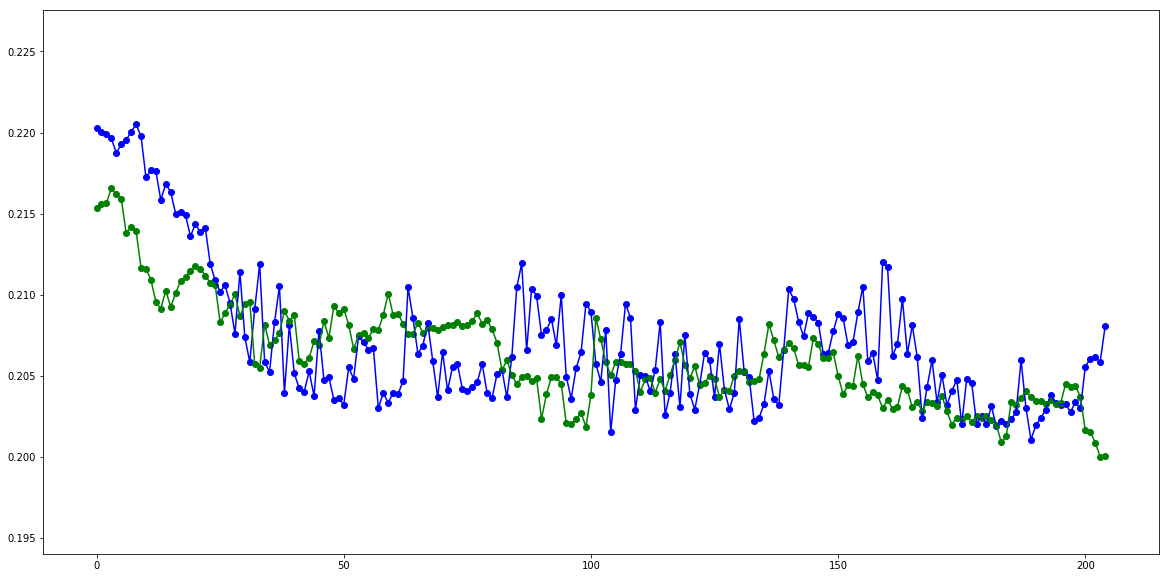

In [11]:
plt.figure(figsize=(20,10))
# visualizer.plot()
# for color in ['blue', 'red']:
# for color in ['red']:
for color in ['blue']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
plt.show()

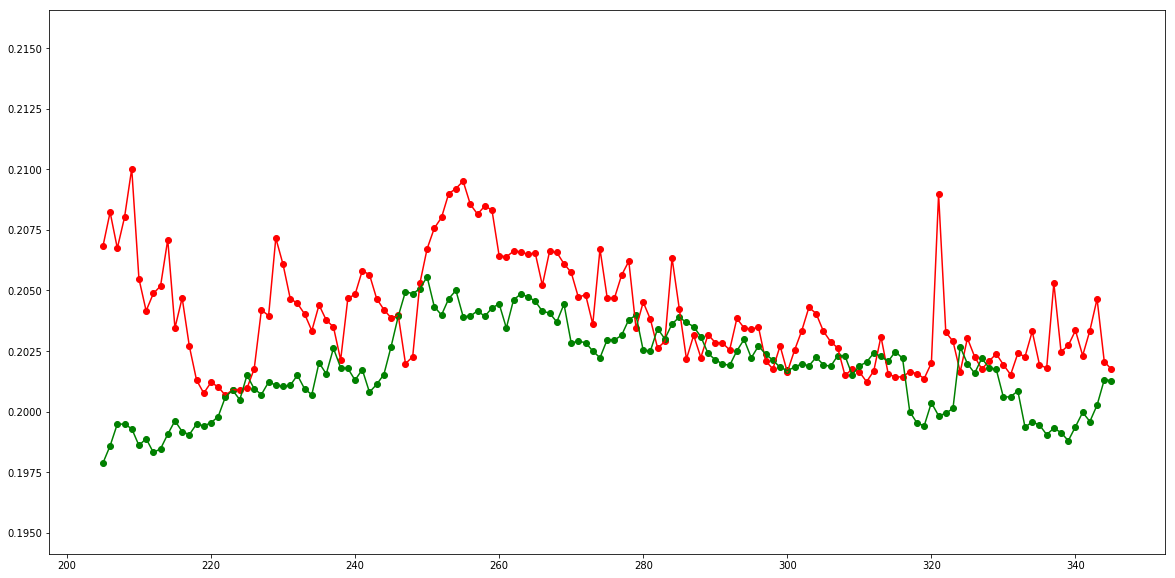

In [12]:
plt.figure(figsize=(20,10))

for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -2]*10], color=color)
#     plt.scatter([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
#     plt.plot([color_df.iloc[0,0]], [color_df.iloc[0, -1]*10], color='g')
plt.show()

# should try estimate (min / max) on next 4 timestamps